# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.utils import *
from pybatina.advanced_weight_recovery import *

In [3]:
guess_range=(-5.0, 5.0)

## Recover multiple secret numbers

In [4]:
SECRET_VALUE='secret value'
GUESSED_VALUE = 'guessed value'
CORRELATION='correlation'
df_index = [SECRET_VALUE, GUESSED_VALUE, CORRELATION]

In [5]:
precision = 1e-3
n_secret_numbers = 5000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
)).astype(np.float32)
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (5000,)


## Batina without noise

### load existing DB

In [6]:
# read the existing data
from os import path
try:
    fname = path.join(TEST_RESULT_DIR, 'advanced_batina_results.csv')
    last_df = pd.read_csv(fname, index_col=0)
    print('read results in %s' % fname)
    print('number of weight values', len(last_df[SECRET_VALUE].unique()))
except FileNotFoundError:
    last_df = pd.DataFrame()
    pass

#last_df = pd.DataFrame()
batina_results = last_df

read results in ./results/advanced_batina_results.csv
number of weight values 2772


### main process

In [7]:
%%time 
wr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=30)
for value in secret_numbers:
    try:
        if value in batina_results[SECRET_VALUE].unique():
            continue
    except KeyError:
        pass
        
    secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * value) for input_values in wr.input_value_set]    
    s = wr.recover_weight(secret_hamming_weight_set)    
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:207: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:207: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:9: RuntimeWarning: overflow encountered in multiply


KeyboardInterrupt: 

In [8]:
batina_results

,guessed value,correlation,secret value
0,-2.328075,1.000000,-2.328075
1,-2.328075,0.835531,-2.328075
2,-2.328026,0.663022,-2.328075
3,-2.328026,0.640260,-2.328075
4,-2.312302,0.569355,-2.328075
...,...,...,...
95095,-4.690083,0.447922,-4.681172
95096,-4.683701,0.447756,-4.681172
95097,-4.690095,0.436610,-4.681172
95098,-4.679639,0.435662,-4.681172


### merge and save DB

In [9]:
print('number of weight values', len(batina_results[SECRET_VALUE].unique()))
batina_results.to_csv(fname)
print('save results in %s' % fname)

number of weight values 3170
save results in ./results/advanced_batina_results.csv


### Statistics

In [10]:
ERROR = 'error'
def statistics(df):
    dft = df[[SECRET_VALUE, GUESSED_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [11]:
batina_best_corr, batina_best_err = statistics(batina_results)

In [12]:
study_score = batina_best_corr
(study_score.T[ERROR] < 1e-3).value_counts()

True     3141
False      29
Name: error, dtype: int64

In [13]:
error_sorted = study_score.T.sort_values(ERROR, ascending=False)
error_sorted[:20]

,secret value,guessed value,correlation,error
29670,-0.265625,-0.004150,0.882927,0.984375
41430,-0.999659,-0.061819,0.683434,0.938160
5460,2.219178,3.508669,0.718290,0.581067
79980,3.437397,3.964837,0.797285,0.153442
72090,4.500485,4.004392,0.682917,0.110231
75930,3.109401,3.423584,0.645306,0.101043
67590,-4.216915,-4.263557,0.684616,0.011061
52350,4.064116,4.103436,0.715209,0.009675
91410,-4.402094,-4.433513,0.749673,0.007137
52800,-1.430008,-1.440063,0.860225,0.007031


In [16]:
error_sorted.iloc[3][SECRET_VALUE]

3.4373974800109863

save results in ./results/advanced_batina_graphs.jpg


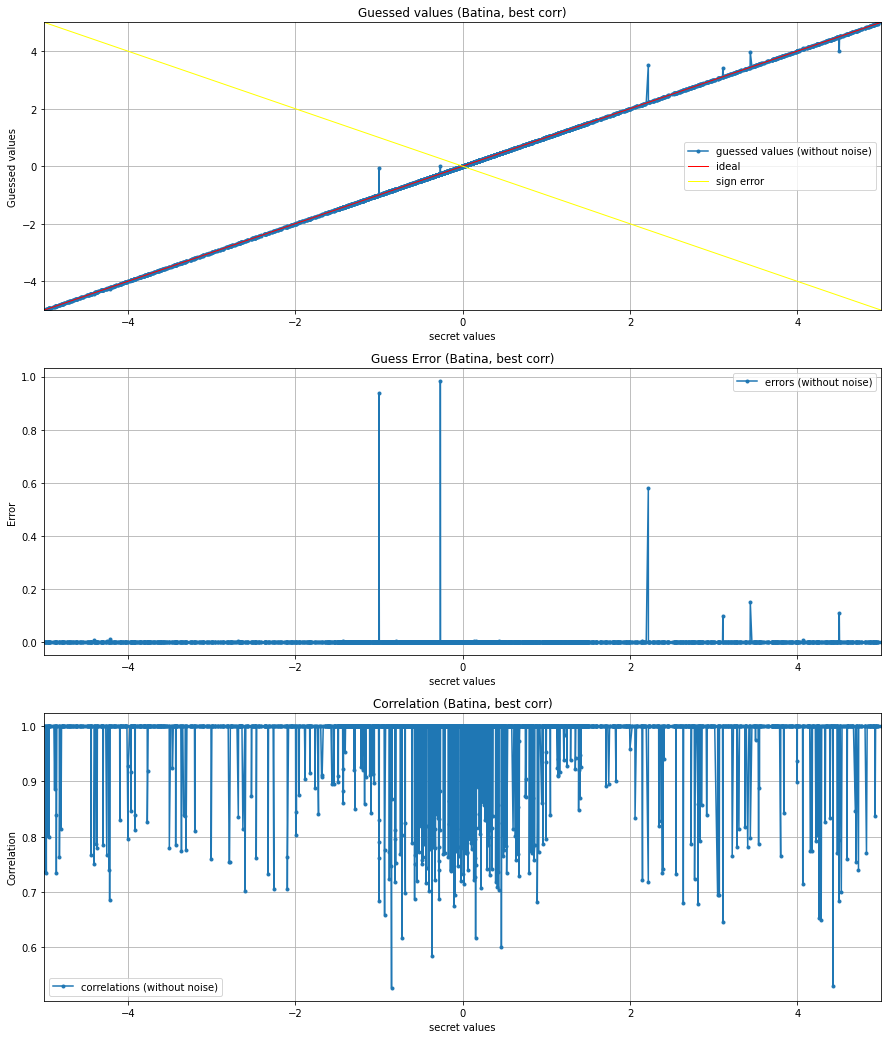

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='guessed values (without noise)')
ax[0].plot(guess_range, guess_range, linewidth=1, label='ideal', color='red')
ax[0].plot([guess_range[1], guess_range[0]], guess_range, linewidth=1, label='sign error', color='yellow')
ax[0].set_ylim(np.min(guess_range), np.max(guess_range))

ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='errors (without noise)')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='correlations (without noise)')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')
    a.set_xlim(np.min(guess_range), np.max(guess_range))

from os import path
fig_fname = path.join(TEST_RESULT_DIR, 'advanced_batina_graphs.jpg')
plt.savefig(fig_fname)
print('save results in %s' % fig_fname)
plt.show()